In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, accuracy_score
from modules.extraction.processing import Preprocessor
from modules.extraction.embedding import EmbeddingExtractor
from modules.retrieval.index import EmbeddingIndex
from modules.retrieval.search import Searcher
from torchvision import transforms


In [ ]:

gallery_dir = 'storage/gallery'
probe_dir = 'simclr_resources/probe'
catalog_dir = 'storage/catalog'

preprocessor = Preprocessor()
embedding_index = EmbeddingIndex(dimension=512)


In [16]:
def compute_metrics(probe_images, true_labels, embedding_extractor, searcher, k=5):
    all_precision = []
    all_recall = []
    y_true_overall = []
    y_pred_overall = []

    for image_path, true_label in zip(probe_images, true_labels):
        preprocessed_image = preprocessor.preprocess(image_path)
        probe_embedding = embedding_extractor.extract(preprocessed_image)

        # knn
        results = searcher.search(probe_embedding, k)
        retrieved_labels = [os.path.basename(os.path.dirname(res['image_path'])) for res in results]
        distances = [res['distance'] for res in results]

        y_true = [1 if label == true_label else 0 for label in retrieved_labels]
        y_scores = [-d for d in distances]  

        y_true_overall.append(1 if true_label in retrieved_labels else 0)
        y_pred_overall.append(1 if true_label in retrieved_labels else 0)

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        all_precision.append(precision)
        all_recall.append(recall)

    accuracy = accuracy_score(y_true_overall, y_pred_overall)

    return all_precision, all_recall, accuracy



Analyzing model: casia-webface


C:\Users\uparp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\uparp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\uparp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\uparp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_ranking.py:980: Us

Accuracy for casia-webface: 1.00
Analyzing model: vggface2


C:\Users\uparp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\uparp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\uparp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\uparp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_ranking.py:980: Us

Accuracy for vggface2: 1.00


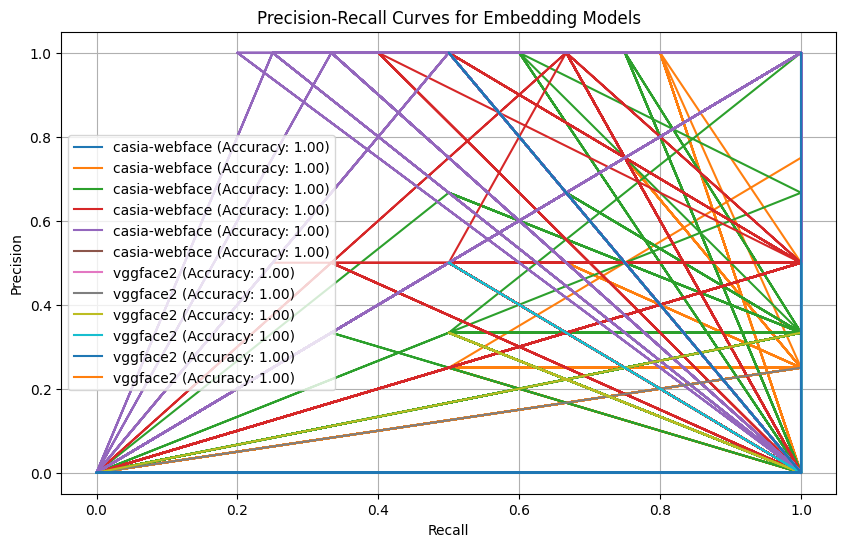

In [18]:
results = {}
for model_name in ['casia-webface', 'vggface2']:
    print(f"Analyzing model: {model_name}")
    
    embedding_extractor = EmbeddingExtractor(model_name=model_name)
    searcher = Searcher(embedding_index)

    embedding_index.load(catalog_dir)

    probe_images = []
    true_labels = []
    for person_folder in os.listdir(probe_dir):
        folder_path = os.path.join(probe_dir, person_folder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                probe_images.append(os.path.join(folder_path, image_file))
                true_labels.append(person_folder)

    precision, recall, accuracy = compute_metrics(probe_images, true_labels, embedding_extractor, searcher)
    results[model_name] = {"precision": precision, "recall": recall, "accuracy": accuracy}

    print(f"Accuracy for {model_name}: {accuracy:.2f}")


plt.figure(figsize=(10, 6))
for model_name, metrics in results.items():
    plt.plot(metrics["recall"], metrics["precision"], label=f"{model_name} (Accuracy: {metrics['accuracy']:.2f})")

plt.title("Precision-Recall Curves for Embedding Models")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


transformations = {
    "Gaussian Blur": transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    "Brightness": transforms.ColorJitter(brightness=0.5),
    "Rotation": transforms.RandomRotation(degrees=30),
}


Applying Transformation: Gaussian Blur
Accuracy after Gaussian Blur: 1.00
Applying Transformation: Brightness
Accuracy after Brightness: 1.00
Applying Transformation: Rotation
Accuracy after Rotation: 1.00


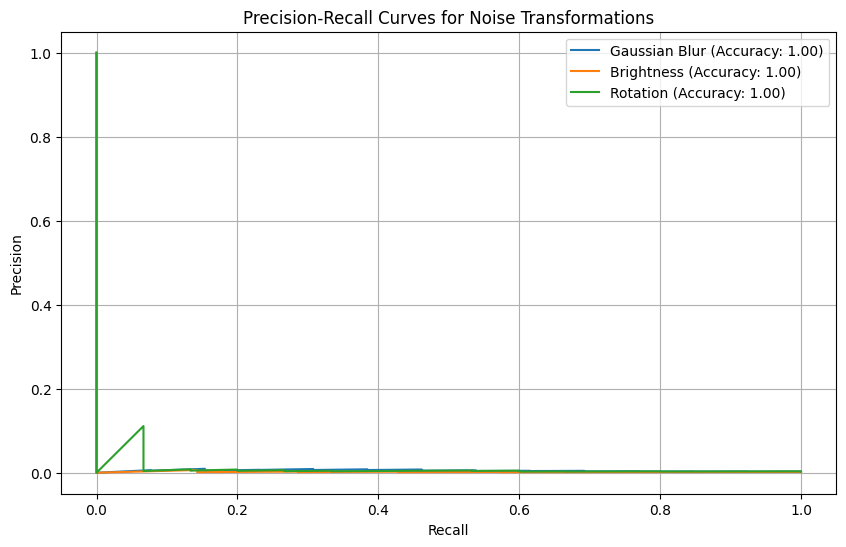

In [19]:

noise_results = {}


for name, transform in transformations.items():
    print(f"Applying Transformation: {name}")
    
    all_y_true = []
    all_y_scores = []

    for image_path, true_label in zip(probe_images, true_labels):
        original_image = preprocessor.preprocess(image_path)
        transformed_image = transform(original_image)

        probe_embedding = embedding_extractor.extract(transformed_image)
        results = searcher.search(probe_embedding, k=5)
        retrieved_labels = [os.path.basename(os.path.dirname(res['image_path'])) for res in results]
        distances = [res['distance'] for res in results]

        y_true = [1 if label == true_label else 0 for label in retrieved_labels]
        y_scores = [-d for d in distances]  

        all_y_true.extend(y_true)
        all_y_scores.extend(y_scores)

    precision, recall, _ = precision_recall_curve(all_y_true, all_y_scores)
    accuracy = accuracy_score(all_y_true, [1 if score > 0 else 0 for score in all_y_scores])

    noise_results[name] = {"precision": precision, "recall": recall, "accuracy": accuracy}

    print(f"Accuracy after {name}: {accuracy:.2f}")

plt.figure(figsize=(10, 6))
for name, metrics in noise_results.items():
    plt.plot(metrics["recall"], metrics["precision"], label=f"{name} (Accuracy: {metrics['accuracy']:.2f})")

plt.title("Precision-Recall Curves for Noise Transformations")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()
